# Cinema: a patriarchal industry? 

**Authors**
- Marjorie Cayatte
- Maxime Leriche
- Madeleine Robert
- Arthur Tabary

**Date**\
December 23rd, 2022

> We first import the library we used for our project. 

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import math
from scipy import stats
from scipy.stats import (gmean,
                        bootstrap)
import json
from datetime import datetime, date, time

# To get data on countries 
import requests

# For plotting graph
import plotly.express as px
import plotly.graph_objects as go

---

## 1 - Get the data

### 1.1 - Import the movies and characters dataset 

We import the following datasets from the **CMU Movie Summary Corpus** as DataFrame: 
- *movie.metadata.tsv.gz*: metadata for 81,741 movies, extracted from the November 4<sup>th</sup>, 2012 dump of Freebase as **movies**. 
- *character.metadata.tsv.gz*: metadata for 450,669 characters aligned to the movies, extracted from the November 4<sup>th</sup>, 2012 dump of Freebase as **characters**. 

In [196]:
# Import movie.metadata and format column names
movies = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv',sep='\t',header=None)
movies.columns=['wiki_movie_ID','freebase_movie_ID','movie_name','movie_release_date','movie_box_off_rev','movie_runtime','movie_languages','movie_countries','movie_genres']
movies.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


- We will clean the DataFrame *movies* by splitting the columns with multiple data into multiple columns. For example, the column "movie_countries" contains the Freebase ID and the country. To do so, we tranform dictionnary in list which will be easier to manipulate. 

In [195]:
# Separate dictionaries into 2 columns with Freebase id and value
movies["movie_countries_id"] = movies["movie_countries"].map(eval).apply(lambda x: list(x.keys()))
movies["movie_countries"] = movies["movie_countries"].map(eval).apply(lambda x: list(x.values()))
movies["movie_genres_id"] = movies["movie_genres"].map(eval).apply(lambda x: list(x.keys()))
movies["movie_genres"] = movies["movie_genres"].map(eval).apply(lambda x: list(x.values()))
movies["movie_languages_id"] = movies["movie_languages"].map(eval).apply(lambda x: list(x.keys()))
movies["movie_languages"] = movies["movie_languages"].map(eval).apply(lambda x: list(x.values()))
movies.head()

TypeError: 'list' object is not callable

In [ ]:
# Load character metadata and format column names
characters = pd.read_csv('Data/MovieSummaries/character.metadata.tsv',sep='\t',header=None)
characters.columns = ['wiki_movie_ID','freebase_movie_ID','movie_release_date','character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age_movie','freebase_char/actor_map_ID','freebase_char_ID','freebase_actor_ID']
characters.head()

,wiki_movie_ID,freebase_movie_ID,movie_release_date,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie,freebase_char/actor_map_ID,freebase_char_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### 1.2 - Transform and clean the dataset

- We notice some corrupted values and correct them. 

In [5]:
# Warning, some rows of the dataset have wrong release dates: here 1010 instead of 2010
movies.iloc[62836]

wiki_movie_ID                                             29666067
freebase_movie_ID                                       /m/0fphzrf
movie_name                                          Hunting Season
movie_release_date                                      1010-12-02
movie_box_off_rev                                       12160978.0
movie_runtime                                                140.0
movie_languages               [Turkish Language, English Language]
movie_countries                                           [Turkey]
movie_genres             [Crime Fiction, Mystery, Drama, Thriller]
movie_countries_id                                     [/m/01znc_]
movie_genres_id       [/m/0lsxr, /m/02n4kr, /m/07s9rl0, /m/01jfsb]
movie_languages_id                        [/m/02hwyss, /m/02h40lc]
Name: 62836, dtype: object

In [6]:
# Replace the wrong value of 1010
movies.loc[62836, 'movie_release_date'] = '2010-12-02'

In [7]:
# Keep only the year of the release date
movies['movie_release_date'] = movies['movie_release_date'].str[:4]

---

## 2 - What is the proportion of women in movies? 

### 2.1 - Gender as a feature

- First, we want to keep only the characters where we have a reported gender. 

In [8]:
# Create a DataFrame keeping only characters where actors have reported gender
characters_gender = characters[characters["actor_gender"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender, the corresponding DataFrame "characters_gender" contains {} rows.'.format(len(characters_gender) / len(characters), len(characters_gender)))

 89.9% of the DataFrame "characters" has reported gender, the corresponding DataFrame "characters_gender" contains 405060 rows.


In [9]:
# What are the possible different values for characters_gender? 
pd.Categorical(characters_gender.actor_gender)

['F', 'F', 'M', 'M', 'F', ..., 'F', 'M', 'F', 'M', 'M']
Length: 405060
Categories (2, object): ['F', 'M']

In [10]:
# creation of a column with "True" for womens
characters_gender['female'] = characters_gender.actor_gender=='F'

# compute percentage of women by movie
percentage_female =  characters_gender.groupby(characters_gender['freebase_movie_ID'])[['freebase_movie_ID','female']].mean()
percentage_female.head()

/var/folders/kv/b4qhyjy15vl3vzcv9jwc36b40000gn/T/ipykernel_6631/1120496318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_gender['female'] = characters_gender.actor_gender=='F'


,female
freebase_movie_ID,
/m/011_mj,0.142857
/m/011_p6,0.400000
/m/011_zy,0.250000
/m/011wtv,0.333333
/m/011x_4,0.294118


### 2.2 - What is the repartition between male and female characters? 

66.72% of reported characters are played by male actors.


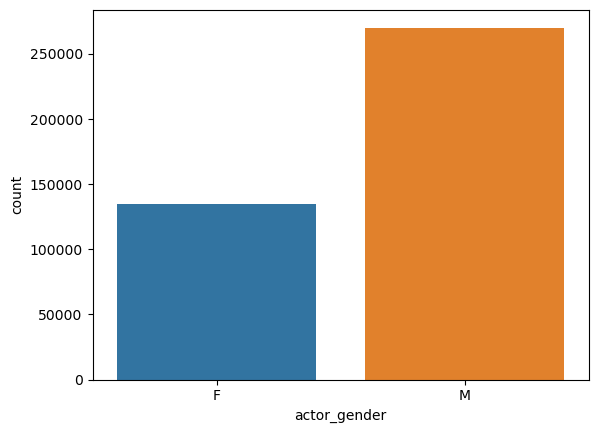

In [11]:
# Create two DataFrame for characters played by female/male
characters_female = characters_gender[characters_gender['actor_gender']== 'F']
characters_male = characters_gender[characters_gender['actor_gender']== 'M']

# Plot the repartition
sns.countplot(x = characters_gender['actor_gender'])
print("{:.2%} of reported characters are played by male actors.".format(len(characters_male)/len(characters_gender)))

### 2.3 - Percentage of female

We create a new DataFrame where we merge *movies* with *percentage_female* to add the percentage of female for each movie. 

In [12]:
movies_female = movies.merge(percentage_female, left_on='freebase_movie_ID', right_on='freebase_movie_ID')
movies_female.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,female
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],0.352941
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],0.266667
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],0.500000
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],0.500000
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],0.333333


- How many movies did we lose by merging? 

In [13]:
print("We kept {:.2%} of the DataFrame movies by merging.".format(len(movies_female)/len(movies)))

We kept 77.87% of the DataFrame movies by merging.


### 2.2 - Temporal evolution of female percentage in movies
- We now want to examine how female percentage in movies evolved over time. 

In [14]:
movies_female_gp_year = movies_female.groupby(movies_female['movie_release_date'])[['female']].mean()
movies_female_gp_year.head()

,female
movie_release_date,
1888,0.50
1891,0.00
1893,0.00
1894,0.25
1895,0.00


- We want to plot the percentage of women over time.

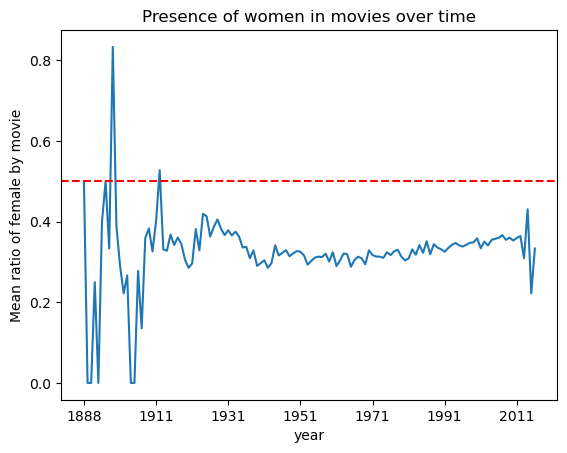

In [15]:
movies_female_gp_year.plot(legend=False)
plt.ylabel('Mean ratio of female by movie')
plt.xlabel('year')
plt.title('Presence of women in movies over time')
plt.axhline(y=0.5,color ='red', ls='--')

---

## 3 - Age and height between male and female characters

We want to compare different features between roles played by male or female: *characters* provides age and height of actors, which can be compared between genders. 

### 3.1 - Comparison of age between male and female 

- We want to compare age of the actors and actresses palying roles reported in *characters*. 

In [16]:
# Clear out characters_gender where age is not reported (characters_gender_age)
characters_gender_age = characters_gender[characters_gender["actor_age_movie"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender and age of the actor/actress; the corresponding \
    DataFrame "characters_gender_age" contains {} rows.'.format(len(characters_gender_age) / len(characters), len(characters_gender_age)))

 64.5% of the DataFrame "characters" has reported gender and age of the actor/actress; the corresponding     DataFrame "characters_gender_age" contains 290770 rows.


- We first explore and clean the data. 

In [17]:
# Explore basic statistics
characters_gender_age.describe()

,wiki_movie_ID,actor_height,actor_age_movie
count,2.907700e+05,139639.000000,290770.000000
mean,1.302929e+07,1.789524,37.804148
std,1.080402e+07,4.380801,20.616015
min,3.300000e+02,0.610000,-7896.000000
25%,3.052538e+06,1.680000,28.000000
50%,1.014264e+07,1.750000,36.000000
75%,2.261175e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


- The negative values do not make sense: we filter them out.

In [18]:
# Keep only rows where "actor_age_movie" is positive
characters_gender_age = characters_gender_age[characters_gender_age['actor_age_movie'] >= 0]

- We plot age of actors in the movie in a boxplot. 

Text(0, 0.5, 'Age (years)')

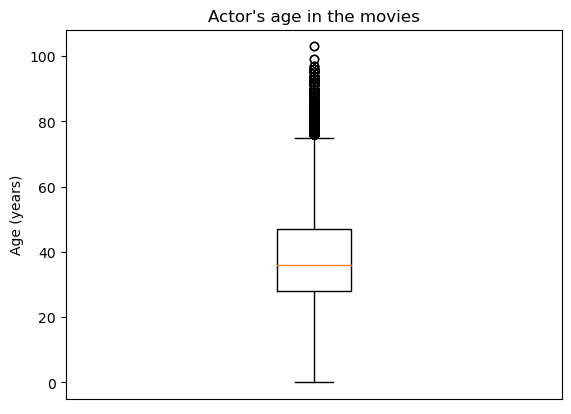

In [19]:
# Plot the distribution of age of actors
plt.boxplot(characters_gender_age['actor_age_movie'])
plt.xticks([])
plt.title("Actor's age in the movies")
plt.ylabel("Age (years)")

- We can visualize age of actors by gender. 

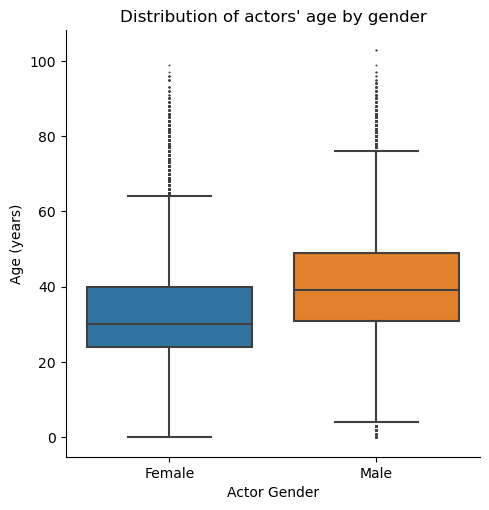

In [20]:
# Plot distribution of age by gender
g = sns.catplot(data=characters_gender_age, x="actor_gender", y="actor_age_movie", kind="box", fliersize=0.5)\
    .set(title="Distribution of actors' age by gender")
g.set_axis_labels("Actor Gender", "Age (years)")
g.set_xticklabels(["Female", "Male"])

### 3.2 - Comparison of height between gender

- We can perform the same analysis for height. 

In [21]:
# Clear out characters_gender where height is not reported (characters_gender_age)
characters_gender_height = characters_gender[characters_gender["actor_height"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender and height of the actor/actress; \
    the corresponding DataFrame "characters_gender_height" contains {} rows.'.format(len(characters_gender_height) / len(characters), len(characters_gender_height)))

 34.3% of the DataFrame "characters" has reported gender and height of the actor/actress;     the corresponding DataFrame "characters_gender_height" contains 154663 rows.


In [22]:
# Explore basic statistics on height
characters_gender_height["actor_height"].describe()

count    154663.000000
mean          1.788966
std           4.382216
min           0.610000
25%           1.676400
50%           1.750000
75%           1.830000
max         510.000000
Name: actor_height, dtype: float64

- 510 cm seems to be a corrupted value. We filter rows where height is above 2,72m (biggest height reported).

In [23]:
# Keep only rows where "actor_height" is below 2.72m
characters_gender_height = characters_gender_height[characters_gender_height['actor_height'] < 2.73]

- Are there other outliers? 

Text(0, 0.5, 'Height (cm)')

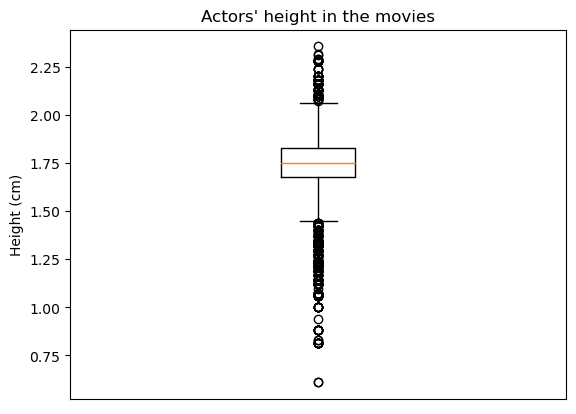

In [24]:
# Plot the distribution of height of actors
plt.boxplot(characters_gender_height['actor_height'])
plt.xticks([])
plt.title("Actors' height in the movies")
plt.ylabel("Height (cm)")

- We can visualize height by gender. 

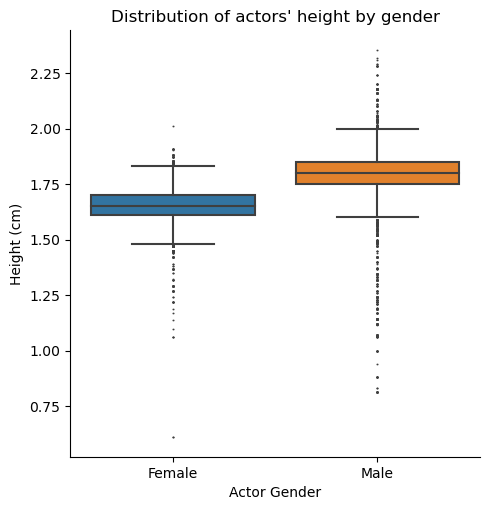

In [25]:
# Plot the distribution of height by gender
g = sns.catplot(data=characters_gender_height, x="actor_gender", y="actor_height", kind="box", fliersize=0.5).\
    set(title="Distribution of actors' height by gender")
g.set_axis_labels("Actor Gender", "Height (cm)")
g.set_xticklabels(["Female", "Male"])

- It seems that male characters have more outliers than female characters. Male characters are also **taller on average** than female characters. 

### 3.3 - Are the observed differences statistically significant? 

- We look at average age and height between male and female characters. 

In [26]:
# In the movies where characters are reported, actresses are on average smaller and younger than men 
characters_gender_grouped = characters_gender.groupby("actor_gender")[[ "actor_age_movie", "actor_height"]].mean()
characters_gender_grouped.head()

,actor_age_movie,actor_height
actor_gender,,
F,32.810753,1.659008
M,40.391679,1.863798


- Are these differences statistically significant? \
To answer this question, we perform an independent sample t-test under the null hypothesis: there is no difference between actors' and actresses'a age. 

In [27]:
# We first extract rows where character is played by a woman or by a man
characters_female_age = characters_gender_age[characters_gender_age['actor_gender']== 'F']
characters_male_age = characters_gender_age[characters_gender_age['actor_gender']== 'M']
print("{:.2%} of characters were gender and age are reported are male.".format(len(characters_male_age)/len(characters_gender_age)))
print("The DataFrame characters_female_age has {} rows, characters_male_age has {} rows.".format(len(characters_female_age), \
    len(characters_male_age)))

65.87% of characters were gender and age are reported are male.
The DataFrame characters_female_age has 99124 rows, characters_male_age has 191277 rows.


In [28]:
# characters_female and characters_male do not have the same shape, we extract 99 242 rows from characters_male to have 
# the same shape to perform an independent t-test
characters_male_age_corr = characters_male_age.sample(n=len(characters_female_age), replace=False)

# We perform the independent sample t-test to compare age of female and male actors
stat_indep_age, pvalue_indep_age = stats.ttest_ind(characters_female_age['actor_age_movie'], characters_male_age_corr['actor_age_movie'])
print("The p-value for the independent sample t-test is: {}".format(pvalue_indep_age))

The p-value for the independent sample t-test is: 0.0


- Here, the p-value is probably below a certain treshold and Pyhton returns 0. \
As the p-value verifies $ p < 0.05 $, actresses are significantly younger in movies of the dataset than actors, with 95% confidence. 

In [29]:
# We now do the same t-test to compare height of male and female actors
characters_female_height = characters_gender_height[characters_gender_height['actor_gender']== 'F']
characters_male_height = characters_gender_height[characters_gender_height['actor_gender']== 'M']
print("{:.2%} of characters were gender and age are reported are male.".format(len(characters_male_height)/len(characters_gender_height)))
print("The DataFrame characters_female has {} rows, characters_male has {} rows.".format(len(characters_female_height), len(characters_male_height)))

63.46% of characters were gender and age are reported are male.
The DataFrame characters_female has 56515 rows, characters_male has 98133 rows.


In [30]:
# characters_female and characters_male do not have the same shape, we extract 56 515 rows from characters_male to have the same shape to perform an independent t-test
characters_male_corr2 = characters_male_height.sample(n=len(characters_female_height), replace=False)

# We perform the independent sample t-test to compare age of female and male actors
stat_indep_height, pvalue_indep_height = stats.ttest_ind(characters_female_height['actor_height'], characters_male_corr2['actor_height'])
print("The p-value for the independent sample t-test is: {}".format(pvalue_indep_height))

The p-value for the independent sample t-test is: 0.0


- Here again the p-value verifies $ p < 0.05 $ so actresses are significantly smaller in movies of the dataset than actors, with 95% confidence. 

### 3.4 - Is there a correlation between age and gender, or between height and gender? 

Is gender correlated with age of actors in the movies ? 

In [31]:
# Transform categorical value "actor_gender" into a numerical one
characters_gender_age_num = pd.get_dummies(data = characters_gender_age[['actor_gender', 'actor_age_movie']])

# We perform a Pearson correlation between gender and age of actors
stats.pearsonr(characters_gender_age_num['actor_gender_F'], characters_gender_age_num['actor_age_movie'])

(-0.2530033181090424, 0.0)

- There is a small (-0.26) but significant ($ p < 0.05 $) negative correlation. 

In [32]:
# We can also examine Spearman rank correlation
stats.spearmanr(characters_gender_age_num['actor_gender_F'], characters_gender_age_num['actor_age_movie'])

SpearmanrResult(correlation=-0.2861287228160736, pvalue=0.0)

- Spearman rank correlation is also significant. 

- These analyses on age and height could be useful in further analyses to understand how characters played by men and women differ and what lead to these differences. 

---

## 4 - Geographic repartition of the movies

### 4.1 - Gather region for each country

- For this part, we use an online API which provides data about each country, and will use the name given in the dataset to gather the corresponding region.

- Since both datasets come from different sources, it is likely that the country names won't match, so we might need to do some changes.

In [33]:
# Get region for each country

region_lst = ["Africa", "Americas", "Asia", "Europe", "Oceania"]
countries = {"country" : [],
"region" : []}

country_lst = [[], []]
df_countries = pd.DataFrame(columns = ["country", "region"])

for region in region_lst:
    response = requests.get("https://restcountries.com/v3.1/region/" + region).json()

    for elem in response:
        countries["country"].append(elem.get("name").get("common"))
        countries["region"].append(region)

df_countries = pd.DataFrame.from_dict(countries)
df_countries.head()

,country,region
0,Eritrea,Africa
1,Ghana,Africa
2,Botswana,Africa
3,Guinea-Bissau,Africa
4,Mauritania,Africa


### 4.2 - Missing countries in the country-region table

We now want to answer the following questions: 
- What are the unreferenced countries?
- For each of these countries, how many movies did they produce/co-produce?
- Which countries represent 95% of all thoses movies? 

We could then **keep only these countries**, and update the country-region reference table. 

There is a total of 8053 movies that contain a null movie name (NaN) among the producing countries (movie_countries column)
98.87% of them only contain 1 NaN occurence, up to 7962.


1    7962
2      83
3       7
5       1
dtype: int64

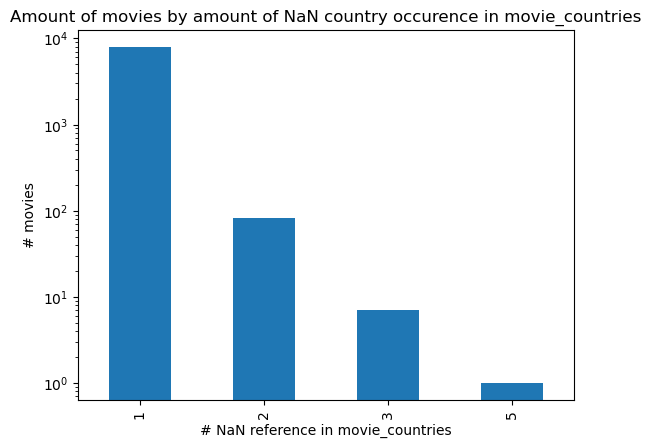

In [34]:
all_movie_countries = movies.explode("movie_countries", ignore_index = True)
unique_movie_countries = all_movie_countries.loc[all_movie_countries["movie_countries"].isnull()]
grunique_movie_countries = unique_movie_countries.groupby("movie_name").size()
grunique_movie_countries = grunique_movie_countries.groupby(grunique_movie_countries).size()
ax = grunique_movie_countries.plot.bar()
ax.set_yscale("log")
ax.set_xlabel("# NaN reference in movie_countries") 
ax.set_ylabel("# movies")
ax.set_title("Amount of movies by amount of NaN country occurence in movie_countries");
print(f"There is a total of {grunique_movie_countries.sum()} movies that contain a null movie name (NaN) among the producing countries (movie_countries column)")
print(f"{grunique_movie_countries.iloc[0]/grunique_movie_countries.sum() :.2%} of them only contain 1 NaN occurence, up to {grunique_movie_countries.max()}.")
grunique_movie_countries

95% of these movies come from ['United States of America' 'West Germany']


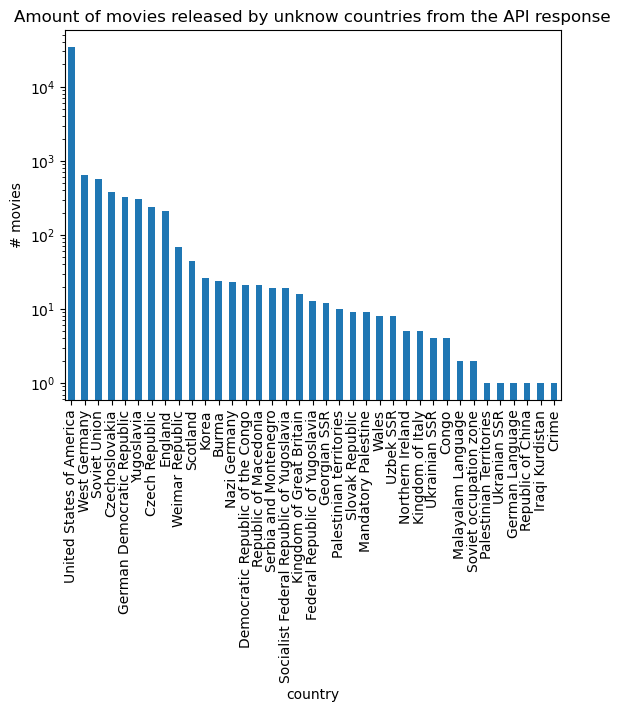

In [35]:
######################################
# What are the unreferenced countries?
######################################

# Get all unique countries in our dataset
all_movie_countries = movies["movie_countries"].explode(ignore_index = True)
unique_movie_countries = all_movie_countries.unique()

# Referenced unique countries
referenced_countries = df_countries["country"].unique()

# Unreferenced countries in the dataset
unreferenced = [a for a in unique_movie_countries if a not in referenced_countries]

###########################################################################
# For each of these countries, how many movies did they produce/co-produce?
###########################################################################

df_unreferenced = all_movie_countries.groupby(all_movie_countries).size()
df_unreferenced = df_unreferenced[df_unreferenced.index.isin(unreferenced)].sort_values(ascending = False)

# Plot
ax = df_unreferenced.plot.bar()
ax.set_yscale("log")
ax.set_xlabel("country") 
ax.set_ylabel("# movies")
ax.set_title("Amount of movies released by unknow countries from the API response");

# Get country names representing 95% of movie quantity
percentile_95 = df_unreferenced.sum() * 0.95
countries_to_keep = df_unreferenced[df_unreferenced.cumsum() <= percentile_95]

print(f"95% of these movies come from {countries_to_keep.index.values}")

# Add these countries to the API dataframe response
countries_to_add = dict(zip(["country", "region"], [countries_to_keep.index.values.tolist(), ["Americas", "Europe"]]))
countries_to_add = pd.DataFrame.from_dict(countries_to_add)
df_countries = pd.concat([df_countries, countries_to_add], ignore_index=True)


# Update the list of unreferenced countries
for country in countries_to_keep.index.values.tolist():
    unreferenced.pop(unreferenced.index(country))

### 4.3 - Clean dataset

- We now remove all movies with a "movie_country" item in one of the unreferenced country we do not want to consider.

In [36]:
movie_count = len(movies)
movies = movies[movies.movie_countries.apply(lambda x: not any(i in unreferenced for i in x))]
print(f"{movie_count - len(movies)} movies were removed.")

2282 movies were removed.


In [37]:
# We do the same for movies_female
movies_female = movies_female[movies_female.movie_countries.apply(lambda x: not any(i in unreferenced for i in x))]

### 4.4 - Add the region information to our dataset

- The *region* column contains the continent in which the movie was produced (can be different regions if multiple countries from different continent co-produced the movie).

In [38]:
# Add region column
# For each country in movies.movie_countries, get the region (remove region duplicates)
def get_region(country_lst):
    output = []
    for country in country_lst:
        try:
            output.append(df_countries.loc[df_countries["country"] == country]["region"].values[0])
        except:
            raise KeyError(f"{country} not found in the reference list")

    #remove duplicates
    return list(set(output))

movies_copy = movies.copy()
movies_copy["region"] = movies_copy.loc[:, ("movie_countries")].apply(lambda x: get_region(x))
movies = movies_copy.copy()
movies.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,region
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],[Americas]
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],[Americas]
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],[Europe]
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],[Europe]
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],[Europe]


In [39]:
# We do the same for movies_female
movies_female_copy = movies_female.copy()
movies_female_copy["region"] = movies_female_copy.loc[:, ("movie_countries")].apply(lambda x: get_region(x))
movies_female = movies_female_copy.copy()
movies_female.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,female,region
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],0.352941,[Americas]
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],0.266667,[Americas]
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],0.500000,[Europe]
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],0.500000,[Europe]
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],0.333333,[Europe]


### 2.5 - Movie repartition by region

- Which regions, or continents, are the most represented in the dataset? 

Text(0.5, 1.0, 'Amount of movies produced by each region')

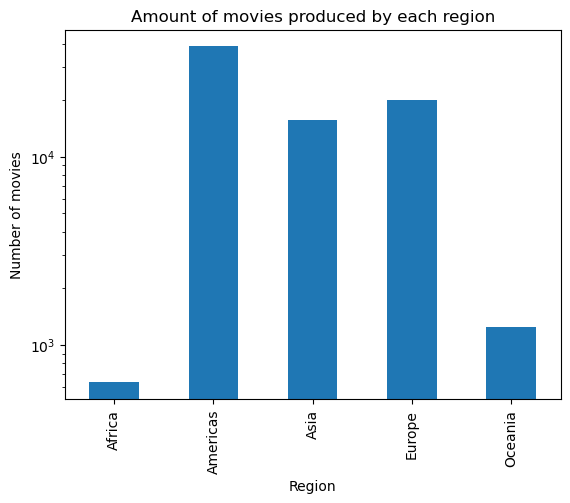

In [40]:
# Plot the distribution of the number of movies by region
movies_region = movies["region"].explode()
movies_region = movies_region.groupby(movies_region).size()
ax = movies_region.plot.bar()
ax.set_yscale("log")
ax.set_xlabel("Region") 
ax.set_ylabel("Number of movies")
ax.set_title("Amount of movies produced by each region")

- As expected, **America** is the **biggest producer** of movie in our dataset, followed by Europe and Asia. The number of movies is much lower in Africa and Oceania. 

___

## 5 - Repartition of gender by region

### 5.1 - Are there regions where female are more represented in the movies? 

In [41]:
# We convert the movie_release_date to float
movies_female['movie_release_date'] = movies_female['movie_release_date'].astype(float)

# We look at the repartition of the dates
movies_female.movie_release_date.describe()

count    58664.000000
mean      1978.670513
std         28.466047
min       1888.000000
25%       1958.000000
50%       1987.000000
75%       2004.000000
max       2016.000000
Name: movie_release_date, dtype: float64


- Are men and women differently represented between regions? 

In [42]:
# We compute the percentage of male
movies_female['male'] = 1 - movies_female['female']
movies_female.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,female,region,male
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],0.352941,[Americas],0.647059
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],0.266667,[Americas],0.733333
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],0.500000,[Europe],0.500000
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],0.500000,[Europe],0.500000
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],0.333333,[Europe],0.666667


- We first create a Dataframe which contains the average percentage of female by region

In [43]:
# Group movies_female by region and compute average percentage
movies_region_grouped = movies_female[['region', 'female', 'male']].explode('region').groupby('region').mean()
movies_region_grouped.head()

,female,male
region,,
Africa,0.321408,0.678592
Americas,0.328914,0.671086
Asia,0.363359,0.636641
Europe,0.336872,0.663128
Oceania,0.338249,0.661751


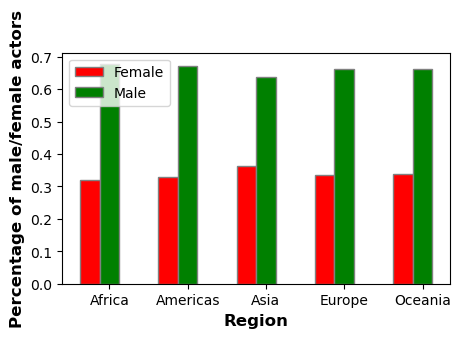

In [44]:
# Plot the percentage of women by region 

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(5, 3))

# set height of bar
F = movies_region_grouped['female']
M = movies_region_grouped['male']
 
# Set position of bar on X axis
br1 = np.arange(len(F))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, F, color ='r', width = barWidth,
        edgecolor ='grey', label ='Female')
plt.bar(br2, M, color ='g', width = barWidth,
        edgecolor ='grey', label ='Male')
 
# Adding Xticks
plt.xlabel('Region', fontweight ='bold', fontsize = 12)
plt.ylabel('Percentage of male/female actors', fontweight ='bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(F))],
        movies_region_grouped.index)
 
plt.legend()
plt.show()

- We first see that in the five regions the percentage of female is lower than the percentage of male. There is no clear difference between the different countries. We could plot a bar plot to visualize the errors bars. 

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,female,region,male
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],0.352941,[Americas],0.647059
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],0.266667,[Americas],0.733333
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],0.500000,[Europe],0.500000
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],0.500000,[Europe],0.500000
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],0.333333,[Europe],0.666667


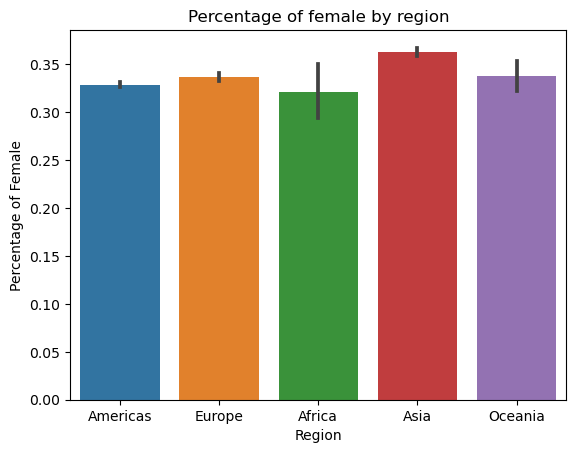

In [45]:
# Plot the percentage of female by region with error bars
ax = sns.barplot(x='region', y='female', data = movies_female.explode('region'))
ax.set(xlabel="Region", ylabel="Percentage of Female", title="Percentage of female by region")

movies_female.head()

- We see that there is no statistically significant differences between the different regions. However, the percentage of female is surprisingly higher in Asia than in other regions of the world. 

- We can also plot using a boxplot to better see the outliers and the repartition of the data. 

[Text(0.5, 0, 'Region'),
 Text(0, 0.5, 'Percentage of Female'),
 Text(0.5, 1.0, 'Percentage of female by region')]

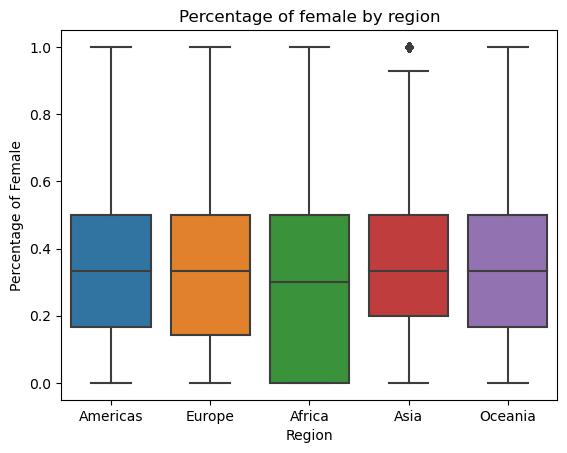

In [46]:
# Plot the percentage of female by region using boxplot
ax = sns.boxplot(x='region', y='female', data=movies_female.explode('region'))
ax.set(xlabel="Region", ylabel="Percentage of Female", title="Percentage of female by region")

### 5.2 - Plot the percentage of female by region for the datastory

- We chose to represent the percentage of female by region using a barplot without the error bars (as they are not significant), with different colors for improved visibility. 

In [47]:
# Create the bar chart
colors = ['#00BFFF', '#DC143C', '#006400', '#FFD700', '#9400D3']

fig = px.bar(movies_region_grouped, x=movies_region_grouped.index, y='female', title='Percentage of female by region',
             labels={'region': 'Region', 'female': 'Percentage of Female'}, color=colors)  

fig.update_layout(title_x=0.5, showlegend=False)
fig.show()


### 5.3 - How does it evolve over time? 

- We can now explore whether this has changed over time. 

In [48]:
# Group movies_female by release year and country
movies_female_gp_year = movies_female.explode('region').groupby(['region', 'movie_release_date'])[['female', 'male']].mean()
movies_female_gp_year.sort_index(ascending=True).head()

female   male
region movie_release_date               
Africa 1933.0               0.000  1.000
       1937.0               0.000  1.000
       1944.0               0.500  0.500
       1947.0               0.500  0.500
       1948.0               0.375  0.625

In [49]:
# Group movies_female only by release year
movies_female_gp_year_only = movies_female.explode('region').groupby(['movie_release_date'])[['female', 'male']].mean()
movies_female_gp_year_only.sort_index(ascending=True).head(10)

,female,male
movie_release_date,,
1888.0,0.500000,0.500000
1891.0,0.000000,1.000000
1893.0,0.000000,1.000000
1894.0,0.250000,0.750000
1895.0,0.000000,1.000000
1896.0,0.400000,0.600000
1897.0,0.500000,0.500000
1898.0,0.333333,0.666667
1899.0,0.833333,0.166667


- We can now plot the evolution of the percentage of female by region over time. 

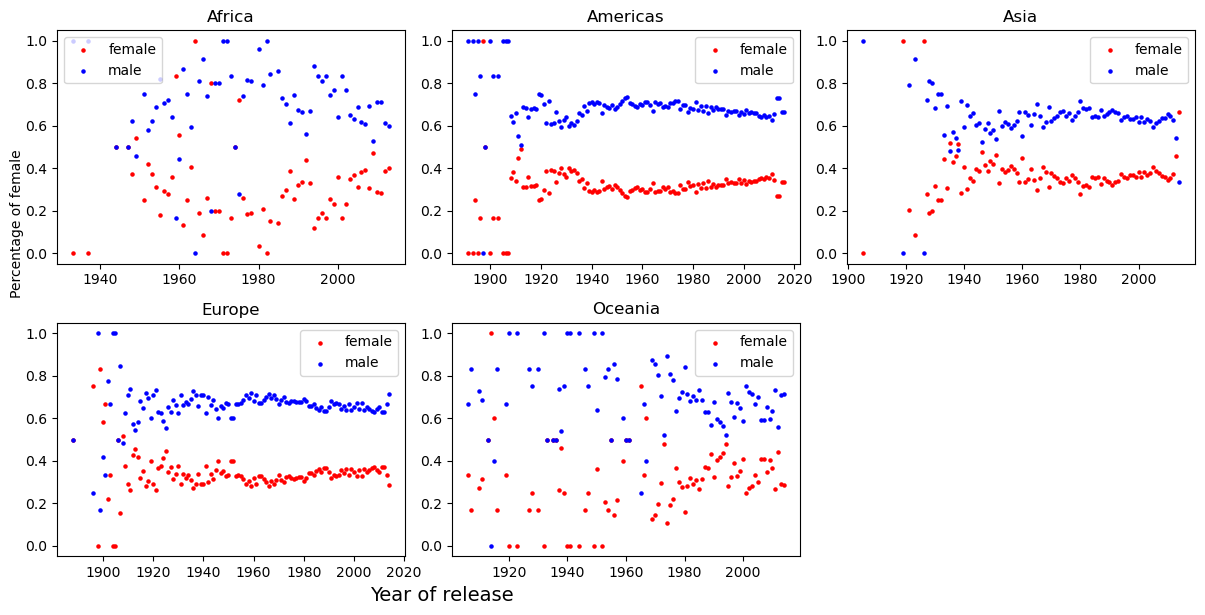

In [50]:
fig = plt.figure(figsize=(12,6))

# We extract a list of the possible values of movie_release date by removing duplicates and NaN 
# We keep only values every 5 years and the corresponding positions in the list

i=1
for idx, data in movies_female_gp_year.groupby(level=0):
    ax = fig.add_subplot(2, 3, i)
    plt.scatter(data.index.get_level_values(level=1), data.female.values, s=5, color='red', label='female')
    plt.scatter(data.index.get_level_values(level=1), data.male.values, s=5, color='blue', label='male')
    #plt.xticks(xticks_position, xticks_labels, rotation=90)
    ax.title.set_text(idx)
    plt.legend()
    i = i+1


fig.tight_layout()

fig.text(0.3,-0.01, "Year of release", fontsize=14)
fig.text(0,0.5, "Percentage of female", rotation = 90)

plt.legend()
plt.show()

> We have interesting and different evolutions depending on the region: 
> - In **Europe, America, and Asia**, it seems that the **trend is stable**. There is much more variation before 1920, which we can interpret by the fact that we have less data for this period. For Europe, the percentage of female seems to have decreased between 1888 and 1918. For Asia, it is the inverse trend. 
> - In **Africa and Oceania**, we have **no clear trend**. Moreover, it seems that there are a lot of **missing values** **after 1980**. 

### 5.4 - Plot the temporal evolution using an interactive plot

- For the datastory, we chose to use an interactive plot so as the viewer can choose the world country to visualize, and we do not need to plot the five plots for the five regions. 

In [51]:
# Initialize figure
fig = go.Figure()

# Set initial conditions
fig.add_trace(    
go.Scatter(x=movies_female_gp_year_only.index,
               y=movies_female_gp_year_only.female, mode="markers", visible=True,
               name='Female', text ='bold',
               line=dict(color="#33CFA5")))

fig.add_trace(    
go.Scatter(x=movies_female_gp_year_only.index,
               y=movies_female_gp_year_only.male, mode="markers", visible=True,
               name='Male', text ='bold',
               line=dict(color="#F06A6A")))

# Add Traces
i=1
for idx, data in movies_female_gp_year.groupby(level=0):
    a1 =  data.index.get_level_values(level=1)
    a2 = data.female.values
    a3 = data.male.values
    fig.add_trace(
    go.Scatter(x=a1,
               y=a2, mode="markers", visible=False,
               name='Female', text ='bold',
               line=dict(color="#33CFA5")))
    fig.add_trace(
    go.Scatter(x=a1,
               y=a3, mode="markers",
               visible=False,
               name='Male',
               line=dict(color="#F06A6A")))

    i = i+1

# Add Buttons

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                   dict(label="World",
                    method="update",
                     args=[{"visible": [True, True, False, False, False, False, False, False, False, False, False, False]},
                           ]),
                dict(label="Africa",
                    method="update",
                     args=[{"visible": [False, False, True, True, False, False, False, False, False, False, False, False]},
                           ]),
                dict(label="America",
                    method="update",
                    args=[{"visible": [False, False, False, False, True, True, False, False, False, False, False, False]},
                            ]),
                dict(label="Asia",
                    method="update",
                    args=[{"visible": [False, False, False, False, False, False, True, True, False, False, False, False]},
                           ]),
                dict(label="Europe",
                    method="update",
                    args=[{"visible": [False, False, False, False, False, False, False, False, True, True, False, False]},
                            ]),
                dict(label="Oceania",
                    method="update",
                    args=[{"visible": [False, False, False, False, False, False, False, False, False, False, True, True]},
                           ]),
            ]),
        )
    ])

# Set title
fig.update_layout(title_text= 'Evolution of actor repartition in the different regions', title_x=0.5, title_y=0.85, xaxis_title='Movie release date', yaxis_title='Percentage by genre')

fig.show()

## 6 - Which genre are included in the dataset? 

In this part, we analyze the feature "movie_genres" to understand how we can include it as a parameter to answer our main question. 

### 6.1 - How many genre a movie has? 

- We first want to know how many genre a movie has to better understand how this characterizes the movie.

In [52]:
# Compute the number of reported genre by movie
movies['nb_genres'] = movies['movie_genres'].str.len()
movies.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,region,nb_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],[Americas],7
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],[Americas],4
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],[Europe],2
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],[Europe],3
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],[Europe],1


- We can look at basic statistics on "nb_genres" and plot the distribution. 

In [53]:
movies['nb_genres'].describe()

count    79459.000000
mean         2.991417
std          2.106219
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         17.000000
Name: nb_genres, dtype: float64

<AxesSubplot:>

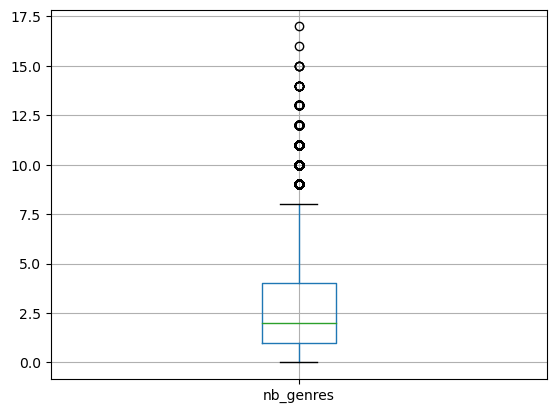

In [54]:
# Plot the distribution of "nb_genres"
movies.boxplot(['nb_genres'])

- According to the previous analyzes, most of the movies have between 1 and 4 genre. Therefore, the genre is a good descriptor of a movie. However, movies can have up to 17 genre, in which case the genre gives less information, which has to be kept in mind for further analyses. 

### 6.2 - What are the genre the most represented in the dataset? 

- We now look at the opposite point of view: **how many movies are reported for each genre?** 

In [55]:
# Explode the list in individual genre and count how many movies are reported for each genre
total_genres = pd.DataFrame(movies.movie_genres.explode().dropna().value_counts())
total_genres.head()

,movie_genres
Drama,32928
Comedy,15999
Romance Film,9958
Black-and-white,8868
Action,8710


<AxesSubplot:title={'center':'Number of movies by genre'}, xlabel='Genres'>

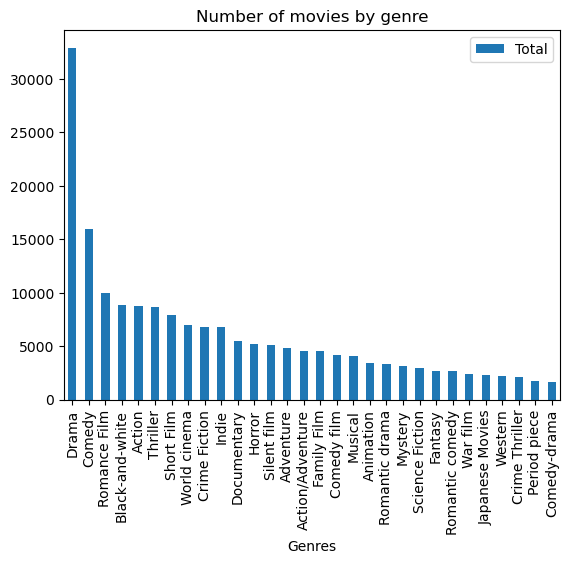

In [56]:
# Plot the number of movies reported for each genre
total_genres.index.name = "Genres"
total_genres = total_genres.rename(columns = {'movie_genres': 'Total'})
total_genres.head(30).plot.bar(y = 'Total', title = "Number of movies by genre")

- Here we see that the number of movies by genre decreases almost exponentially. Among the genre in the tail, we find cross genre like "Romantic Thriller" or error of typology like "Comdedy". There are also some categories which are not stricly genre like "silent movie" or "black and white". Keeping them in our analysis does not seem pertinent as they do not reflect a trend intrinsic to a genre.

- For future analyses on genre, we chose to retain only the **5 genre the most represented in the dataset**, excluding the "Black and White" category, which we not consider as a genre: 
    - Drama
    - Comedy 
    - Romance film 
    - Action
    - Thriller

- This choice is supported by the fact that they correspond to natural responses one would answer when asked about most represented genre.

### 6.3 - Evolution over time

- Has the evolution of most represented genre changed over time?  

In [57]:
# Group by "movie_release_date"
movies_per_year_grouped = movies.groupby(movies['movie_release_date'])

# Compute the number of movies by year and by genre
total_genres_per_year = total_genres
years = ['Total']
for year, group in movies_per_year_grouped[['movie_release_date', 'movie_genres']]:
    total_genres_per_year = pd.concat([total_genres_per_year, group.movie_genres.explode().dropna().value_counts()], axis = 1)
    years.append(year)
total_genres_per_year.columns = years
total_genres_per_year.index.name = 'Genres'
total_genres_per_year.head()

,Total,1888,1889,1890,1891,1892,1893,1894,1895,1896,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Genres,,,,,,,,,,,,,,,,,,,,,
Drama,32928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,997.0,975.0,953.0,895.0,826.0,425.0,44.0,4.0,NaN,NaN
Comedy,15999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,...,488.0,509.0,441.0,388.0,263.0,98.0,10.0,1.0,NaN,NaN
Romance Film,9958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,328.0,346.0,314.0,282.0,257.0,171.0,13.0,3.0,NaN,1.0
Black-and-white,8868,1.0,1.0,NaN,NaN,NaN,1.0,7.0,11.0,19.0,...,3.0,2.0,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN
Action,8710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,238.0,285.0,266.0,287.0,293.0,187.0,44.0,1.0,2.0,1.0


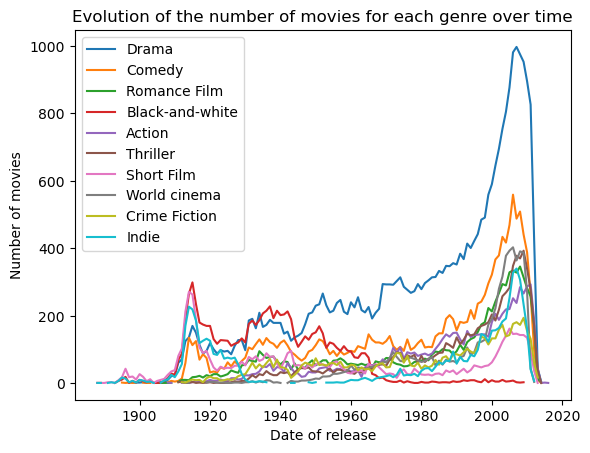

In [58]:
# Plot the evolution of the number of movies by genre for the top 10
x = np.array(total_genres_per_year.columns[1:], dtype = 'datetime64[ms]')
plt.figure()
for index, row in total_genres_per_year.head(10).iterrows():
    plt.plot(x, row[1:], label = index)
plt.legend()
plt.xlabel("Date of release")
plt.ylabel("Number of movies")
plt.title("Evolution of the number of movies for each genre over time")
plt.show()

- By looking at the number of genre per year, we see a **similar evolution for every genre.** For every genre the number of movies highly increases over time,  except for "black and white" movies. The striking drop around 2010 probably corresponds to time of extraction of the database (2012).

- We can look at the counts. 

In [59]:
movies_per_year_grouped[['movie_release_date']].size().reset_index(name='counts').sort_values(by = 'movie_release_date', ascending= False).head(10)

,movie_release_date,counts
128,2016,3
127,2015,4
126,2014,17
125,2013,162
124,2012,1189
123,2011,1798
122,2010,2008
121,2009,2221
120,2008,2440
119,2007,2365


- As we can see here, values are incoherent after 2013. Therefore, we will **cut off after 2012 (included)**, which is coherent with the date of extraction of the database. 

- According to the following graph made with IMDB dataset, the behavior of the number of movie by year is similar, which supports the hypothesis that the dataset provides evolution close to reality.
![films-released-yearly](films-released-all-time-yearly.png)

___

## 7 - Repartition of gender by genre

### 7.1 - Percentage of female by genre

In [60]:
# Create a new dataset where movie genres are put into separate lines
movie_genres_female_exploded = movies_female[['movie_genres', 'female']].explode('movie_genres').dropna()

# Rename the colum 
movie_genres_female_exploded = movie_genres_female_exploded.rename(columns = {'female': 'female_ratio'})

# Compute the average of the ratio of female per genre
movie_genres_female_mean = movie_genres_female_exploded.groupby('movie_genres').mean()

# Keep only the selected genres
bool = ((movie_genres_female_mean.index == 'Drama') |
        (movie_genres_female_mean.index == 'Comedy')|
        (movie_genres_female_mean.index == 'Romance Film')|
        (movie_genres_female_mean.index == 'Action')|
        (movie_genres_female_mean.index == 'Thriller'))

movie_genres_female = movie_genres_female_mean[bool]
movie_genres_female.head()

,female_ratio
movie_genres,
Action,0.255917
Comedy,0.327129
Drama,0.368258
Romance Film,0.405766
Thriller,0.317919


In [61]:
# Group by genre and by release date 
movies_female_gp_year_genre = movies_female.explode('movie_genres').dropna().groupby(['movie_genres', 'movie_release_date'])[['female', 'male']].mean()
movies_female_gp_year_genre.head()

female      male
movie_genres movie_release_date                    
Absurdism    1971.0              0.176471  0.823529
             1976.0              0.272727  0.727273
             1977.0              0.154762  0.845238
             1978.0              0.217391  0.782609
             1979.0              0.230769  0.769231

In [62]:
# Keep only the selected genres
movies_female_gp_year_5genre = movies_female_gp_year_genre.loc[['Drama', 'Comedy', 'Action', 'Thriller', 'Romance Film']]
movies_female_gp_year_5genre.head(100)
len(movies_female_gp_year_5genre)

416

- Now that we have the average of the ratio per genre, we will test two ways to represent the results: bar plot and box plots

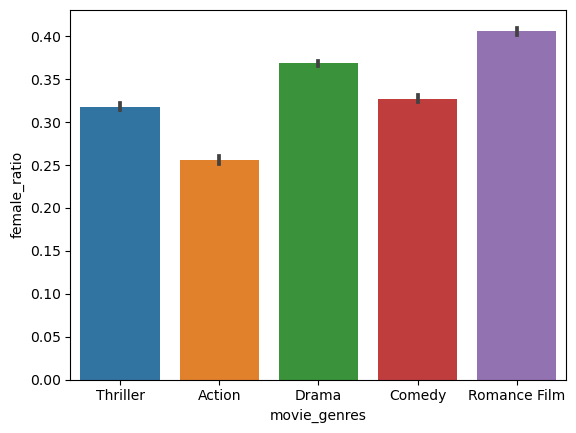

In [63]:
ax = sns.barplot(x="movie_genres", y="female_ratio", data=movie_genres_female_exploded.loc[movie_genres_female_exploded['movie_genres'].isin(['Drama', 'Comedy', 'Romance Film', 'Action', 'Thriller'])])

> We can see that we have statistical differences between the genre. The one with the highest percentage of women is romance film, which is expected, followed by drama, which is also logic. Then thriller, comedy and action are in this decreasing order, where once again action movies could have been expected to have less women playing in it. 

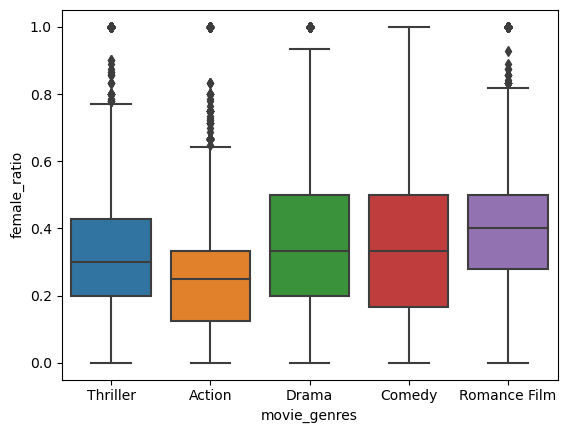

In [64]:
# Other way, maybe clearest, to represent the same thing
ax = sns.boxplot(x="movie_genres", y="female_ratio", data=movie_genres_female_exploded.loc[movie_genres_female_exploded['movie_genres'].isin(['Drama', 'Comedy', 'Romance Film', 'Action', 'Thriller'])])

### 7.2 - How does it evolve over time? 

> We can now see how if tendency has evolved over time. 

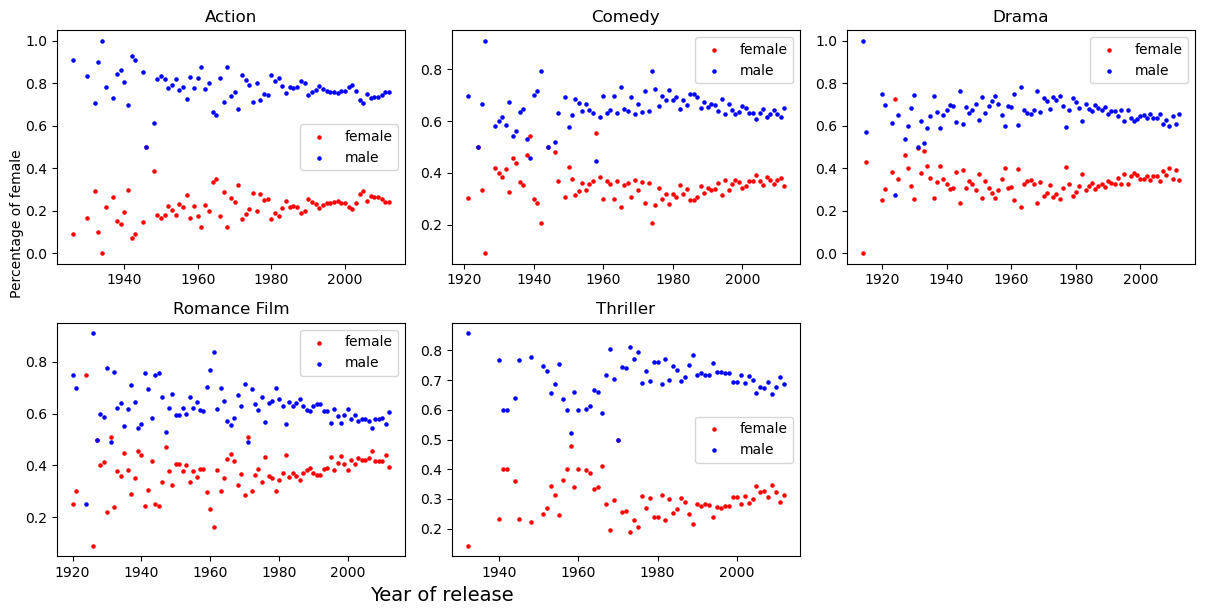

In [65]:
fig = plt.figure(figsize=(12,6))

i=1
for idx, data in movies_female_gp_year_5genre.groupby(level=0):
    ax = fig.add_subplot(2, 3, i)
    plt.scatter(data.index.get_level_values(level=1), data.female.values, s=5, color='red', label='female')
    plt.scatter(data.index.get_level_values(level=1), data.male.values, s=5, color='blue', label='male')
    ax.title.set_text(idx)
    plt.legend()
    i = i+1


fig.tight_layout()

fig.text(0.3,-0.01, "Year of release", fontsize=14)
fig.text(0,0.5, "Percentage of female", rotation = 90)

plt.legend()
plt.show()

> We can see that we have different trends for the different genre: for drama and romance film, the percentage of women seems to e stable over the years, and we have no more data after 1978. For action and thriller, there is much more variance, and we have no more data after 1958. For comeddy, we have a lot of variance before 1928 then it stabilizes between 1918 and 1968. 

---

## 8 - How to evaluate the success of a movie ? 

In our dataset, the only feature we have to measure the success of a movie is the **box office revenue**. We will first analyze this feature in our dataset. 

### 8.1 - Cleaning and missing values

In [66]:
# How many movies have a missing box office revenue value? 
print("{:.2%} of the movies have a missing movie box office revenue value.".format(movies.isnull().sum()['movie_box_off_rev']/len(movies)))

89.52% of the movies have a missing movie box office revenue value.


- How are the missing values distributed over time ? 
- We calculate the number of movies per year which have a reported box office revenue. 

In [67]:
# Keep only movies with a value for box office revenue
movies_with_bor = movies[movies.movie_box_off_rev.isnull()==False]

# Group by year and count the number of movies
movies_with_bor_gp_year = movies_with_bor.groupby(movies_with_bor['movie_release_date'])[['movie_release_date']].count()
movies_with_bor_gp_year.head()

,movie_release_date
movie_release_date,
1897,1
1914,4
1915,1
1920,1
1921,3


- To plot evolution of movies without missing values over time, we normalize on the total number of movies, as we saw in 2 that it strongly increased over time. 

In [68]:
# Compute number of movies with missing values over total number of movies per year
movie_count_all_gp_year = movies.groupby(movies['movie_release_date'])[['movie_release_date']].count()
movie_count_all_gp_year['ratio_bor']=movies_with_bor_gp_year['movie_release_date']/movie_count_all_gp_year['movie_release_date']

Text(0.5, 1.0, 'Ratio of values available per year for the feature "movie_box_off_rev"')

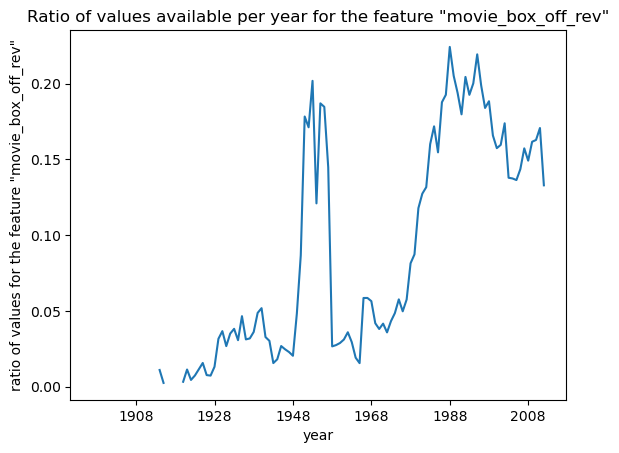

In [69]:
#Plot the distribution
movie_count_all_gp_year['ratio_bor'].plot(legend=False)
plt.ylabel('ratio of values for the feature "movie_box_off_rev"')
plt.xlabel('year')
plt.title('Ratio of values available per year for the feature "movie_box_off_rev"')

- We can see that the **ratio of movies with a value for box office revenue increases with time**; however, the ratio never exceeds 20% of the dataset, which is quite low. 

### 8.2 - Evolution of average box office revenue over time

- We now want to analyze the evolution of the box office revenue over time. 

In [70]:
# Compute the average box office revenue by year
movies_mean_bor_gp_year = movies_with_bor.groupby(movies_with_bor['movie_release_date'])[['movie_box_off_rev']].mean()
movies_mean_bor_gp_year.head()

,movie_box_off_rev
movie_release_date,
1897,1.000000e+05
1914,7.079320e+05
1915,5.000000e+07
1920,4.500000e+06
1921,2.633333e+06


Text(0.5, 1.0, 'Evolution of the average box office revenue')

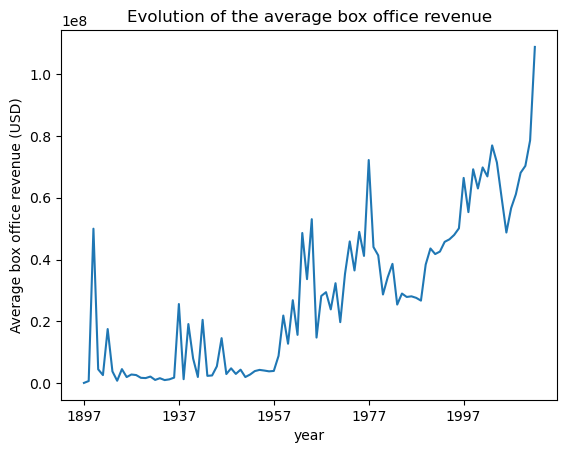

In [71]:
# Plot the distribution
movies_mean_bor_gp_year.plot(legend=False)
plt.ylabel('Average box office revenue (USD)')
plt.xlabel('year')
plt.title('Evolution of the average box office revenue')

* To be perfectly accurate in comparing box office receipt comparison over time, we should adjust revenues for dollar inflation. One could go further and consider even more adjustements to be even more precise as explained in [this article](https://wwwold.usi.edu/media/3655032/How-the-MPA-Miscalculates.pdf).

- Even if these results are interesting, the amount of missing values is quite problematic. To evaluate the success of a movie, we can also look at the ratings of the movies. The data is not available in our dataset but we can use IMDb.

### 8.3 - Get the IMDb dataset

In [72]:
# Import dataset title.basics and title.ratings
imdb_data_df = pd.read_csv('Data/Imdb/title.basics.tsv', sep = '\t')
imdb_ratings_df = pd.read_csv('Data/Imdb/title.ratings.tsv', sep = '\t')

imdb_data_df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Imdb/title.basics.tsv'

In [ ]:
imdb_ratings_df.head(10)

NameError: name 'imdb_ratings_df' is not defined

In [ ]:
# Merge imdb_data_df and imdb_ratings_df on ratings
rating_df = imdb_data_df.merge(imdb_ratings_df)

NameError: name 'imdb_data_df' is not defined

In [ ]:
# Delete unnessary columns  
rating_df = rating_df.drop(['isAdult', 'endYear'], axis = 1)

NameError: name 'rating_df' is not defined

In [73]:
rating_df.iloc[423117]

NameError: name 'rating_df' is not defined

In [74]:
#Replace \N by NaN, replace corrupted values, drop missing values and convert run time into numerical data
rating_df[['runtimeMinutes', 'startYear']] = rating_df[['runtimeMinutes', 'startYear']].replace(r"\N", np.NaN).replace("Game-Show", np.NaN).replace("Game-Show,Reality-TV", np.NaN).dropna(subset = ['runtimeMinutes', 'startYear'])
rating_df = rating_df.dropna(subset = 'runtimeMinutes')
rating_df['runtimeMinutes'] = pd.to_numeric(rating_df['runtimeMinutes'])

NameError: name 'rating_df' is not defined

In [75]:
# Merge movies with ratings_df on primary title and start year
merged_rating_df = movies.merge(rating_df, left_on = ['movie_name', 'movie_release_date'], right_on = ['primaryTitle', 'startYear'])
merged_rating_df.head()

NameError: name 'rating_df' is not defined

- There are some duplicates because of the merge, we have to treat them. 

In [76]:
# Remove duplicates
merged_rating_df[merged_rating_df.duplicated(subset = ['freebase_movie_ID'], keep=False)]

NameError: name 'merged_rating_df' is not defined

- We can finally export the final dataset by keeping only columns of interest

In [77]:
# Keep only column of interest and export the final dataset
merged_rating_df = merged_rating_df.drop_duplicates(subset = 'freebase_movie_ID', keep = 'first')
merged_rating_df[['freebase_movie_ID', 'tconst', 'titleType', 'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes', 'genres','averageRating', 'numVotes']].to_csv('Data/Imdb/processed_imdb_dataset.csv')

NameError: name 'merged_rating_df' is not defined

### 8.4 - Rating of movies

In [78]:
imdb = pd.read_csv('Data/Imdb/processed_imdb_dataset.csv')
imdb.head()

,Unnamed: 0,freebase_movie_ID,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,0,/m/03vyhn,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55235
1,1,/m/0crgdbh,tt0094806,movie,Brun bitter,Brun bitter,1988,83,"Crime,Drama",5.7,40
2,2,/m/01mrr1,tt0083949,movie,A Woman in Flames,Die flambierte Frau,1983,106,Drama,6.0,589
3,3,/m/03cfc81,tt0002894,short,The Gangsters,The Gangsters,1913,35,"Comedy,Short",6.8,16
4,4,/m/02qc0j7,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2159


- We can start by computing the average rating by year

In [79]:
#Group rating by year and compute mean rating 
imdb_rating_gp_year = imdb.groupby(imdb['startYear'])[['averageRating']].mean()
imdb_rating_gp_year.head()

,averageRating
startYear,
1888,7.300000
1889,5.000000
1890,5.200000
1891,4.966667
1892,6.050000


Text(0.5, 1.0, 'Evolution of movie ratings')

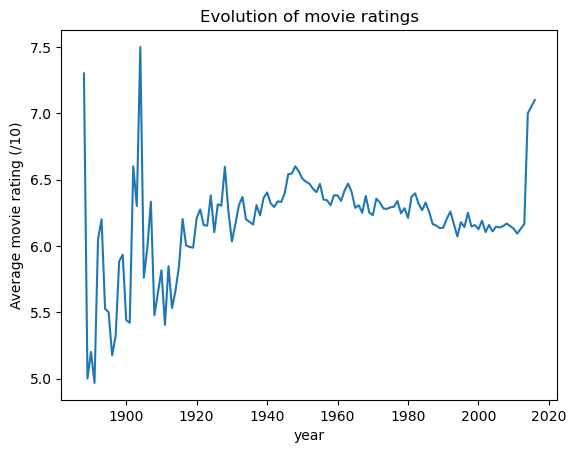

In [80]:
#Plot the distribution
imdb_rating_gp_year.plot(legend=False)
plt.ylabel('Average movie rating (/10)')
plt.xlabel('year')
plt.title('Evolution of movie ratings')

In [81]:
# Merge imdb et movie metadata
imdb.sort_values(by = 'startYear', ascending = False).head()

,Unnamed: 0,freebase_movie_ID,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
16661,17361,/m/0c03gcc,tt2267968,movie,Kung Fu Panda 3,Kung Fu Panda 3,2016,95,"Action,Adventure,Animation",7.1,159714
27214,28351,/m/0j9m0k2,tt2357291,movie,Rio 2,Rio 2,2014,101,"Adventure,Animation,Comedy",6.3,91239
28884,30082,/m/0k3lpxc,tt5308316,tvEpisode,Saving Mr. Banks,Saving Mr. Banks,2014,6,"Documentary,Short",7.4,15
30259,31517,/m/0k0tq97,tt1587310,movie,Maleficent,Maleficent,2014,97,"Adventure,Family,Fantasy",6.9,375978
39092,40653,/m/0fkf28,tt0816692,movie,Interstellar,Interstellar,2014,169,"Adventure,Drama,Sci-Fi",8.6,1803725


### 8.5 - Correlation between rating and box office revenue

- Now we have two measures of a movie's success and we wonder wether these two features are correlated. As we saw in the previous parts, there are many missing values on box office revenues. If these two features are strongly correlated, we could keep only rating as a measure of success and have a larger dataset to work on. 

In [82]:
# Merge movies with box office revenue and dataset with ratings on freebase_movie_ID
correl = movies_with_bor.merge(imdb, left_on='freebase_movie_ID', right_on='freebase_movie_ID')
correl.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,...,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],...,0,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55235
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",[/m/09c7w0],...,4,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2159
2,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",[/m/07ssc],...,7,tt0097499,movie,Henry V,Henry V,1989,137,"Biography,Drama,History",7.5,30162
3,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",[/m/09c7w0],...,8,tt0058331,movie,Mary Poppins,Mary Poppins,1964,139,"Comedy,Family,Fantasy",7.8,173169
4,156558,/m/014k4y,Baby Boy,2001,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",[/m/09c7w0],...,14,tt0255819,movie,Baby Boy,Baby Boy,2001,130,"Crime,Drama,Romance",6.4,14981


In [83]:
#Compute Pearson correlation coefficient
stats.pearsonr(correl['movie_box_off_rev'],correl['numVotes'])

(0.6451295059726349, 0.0)

- The Pearson linear coefficient is low but significantly positive ($ p < 0.05$). The correlation seems too low to keep only one feature as a measure of success. Therefore we could **keep both** for further analyses and draw different conclusions from their exploitation. 

---

## 9 - What is the typical profile of a character? 

- In this part, we want to use the character types as identified by Bamman & al and try to identify typical characteristics of these characters, and see the differences between gender. 

### 9.1 - Get the data and pre-process it 

In [135]:
# import tvtropes.clusters
type_char=pd.read_table('Data/MovieSummaries/tvtropes.clusters.txt',header=None)

# Rename the columns
type_char.columns=['char_type','infos']

# Print the dataframe
type_char.head()

,char_type,infos
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


In [137]:
# Split the dictionnaries into columns

list=[]
for i in range(len(type_char)):
    list=list+[json.loads(type_char['infos'][i])]

char_type_df = pd.DataFrame(list)
char_type_df.head(3)

,char,movie,id,actor
0,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen


In [138]:
# Add the char_type column
char_type_df['char_type']=  type_char['char_type']

# Rename the columns
char_type_df.columns=['character_name','movie_name','freebase_char/actor_map_ID','actor_name','char_type']

# Keep only the columns of interest
char_type_df = char_type_df[['freebase_char/actor_map_ID','char_type']]

char_type_df.head(3)

,freebase_char/actor_map_ID,char_type
0,/m/0jy9q0,absent_minded_professor
1,/m/02vchl3,absent_minded_professor
2,/m/0k6fkc,absent_minded_professor


In [140]:
# Merge with characters_gender (charcters with no missing values on gender)
type_character = characters_gender.merge(char_type_df, left_on='freebase_char/actor_map_ID', right_on='freebase_char/actor_map_ID')
type_character.head()

,wiki_movie_ID,freebase_movie_ID,movie_release_date,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie,freebase_char/actor_map_ID,freebase_char_ID,freebase_actor_ID,female,char_type
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,/m/041rx,Dustin Hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,False,tranquil_fury
1,1157158,/m/04c13q,2002-03-29,Sheldon Mopes,1969-08-18,M,1.83,NaN,Edward Norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,False,granola_person
2,504242,/m/02j9_2,2005-08-22,Mr. Universe,1978-05-15,M,1.68,/m/041rx,David Krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,False,playful_hacker
3,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,False,charmer
4,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,False,loveable_rogue


### 9.2 - Explore the character types by gender

- We want to extract the most reccurent adjectives used to describe the male and female characters to get an insight of the "typical character" for each gender. 

In [147]:
# For males
# Explode the character types to get all the adjectives independently and count the occurence of each adjective
type_male = type_character[type_character.female==False]['char_type'].str.split('_').explode().value_counts()
type_male = type_male.to_frame()

# Drop words that are not adjectives
type_male=type_male[~(type_male.index.isin(['guy','a','to','for','man','his','men','with','the']))]
type_male.head(10)

,char_type
crazy,28
jealous,25
corporate,23
executive,23
corrupt,23
hero,17
byronic,17
hunter,17
hire,16
psycho,16


- As we can see, among the most recurrent words we have positive one "corporate", "executive", "hero", as well a negative ones "crazy", "jealous". 

In [148]:
# Same processus for females
type_female = type_character[type_character.female==True]['char_type'].str.split('_').explode().value_counts()
type_female = type_female.to_frame()
type_female=type_female[~(type_female.index.isin(['girl','final','valley','person']))]
type_female.head(10)

,char_type
dumb,10
blonde,10
brainless,7
beauty,7
prima,6
chanteuse,6
donna,6
ophelia,5
granola,4
broken,4


- We also see negative words, which correspond to the stereotype one can have of the role of a female character in some movies: "dumb", "brainless", "blonde". 

In [145]:
# Export to csv
type_male.to_csv('type_male.csv', sep=';')
type_female.to_csv('type_female.csv', sep=';')

---

## 10 - Are the characters played by women "important" characters? 

### 10.1 - Import the data

- We first import the *plot_summaries* dataframe 

In [84]:
# Read plot dataset
plot_df = pd.read_csv('Data/MovieSummaries/plot_summaries.txt', names = ['wiki_movie_ID', 'plot'], delimiter= '	')

In [86]:
# Sorted out the characters and plot dataframe to keep only the matching wiki_movie_ID rows
characters_filtered = characters.dropna(subset = 'character_name')
characters_filtered = characters_filtered[characters_filtered.wiki_movie_ID.isin(plot_df.wiki_movie_ID)]
plot_df_filtered = plot_df[plot_df.wiki_movie_ID.isin(characters_filtered.wiki_movie_ID)]

### 10.2 - Importance by appearance of the name in the plot

- We then want to know if a character has an importance in a movie. A method to assess the importance is to determine **whether the name of the character appears - even just partly -  in the plot summary**. The following functions does this task. 

In [87]:
# Function to determine if a character's full name or just a part, appears in the plot
count_apparition = []
for index, row in characters_filtered.iterrows():
    names = row.character_name.split(' ')
    count = 0
    for word in names:
        if word in plot_df_filtered[plot_df_filtered.wiki_movie_ID == row.wiki_movie_ID]['plot'].item():
            count = 1
            break
    count_apparition.append(count)
characters_filtered['mentionned_in_the_plot'] = count_apparition
characters_filtered['mentionned_in_the_plot'] = pd.to_numeric(characters_filtered['mentionned_in_the_plot'])
characters_filtered.head()

,wiki_movie_ID,freebase_movie_ID,movie_release_date,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie,freebase_char/actor_map_ID,freebase_char_ID,freebase_actor_ID,mentionned_in_the_plot
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,1
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,1
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,1
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,0


- We can now compute the **mean of the character name's mention** in movies summaries

In [90]:
# Now we compute the mean of a mention in movie summaries per actors over all his or her movies
characters_grouped = characters_filtered[['freebase_actor_ID', 'mentionned_in_the_plot', 'actor_gender']].groupby(by = ['actor_gender', "freebase_actor_ID"]).agg('mean')
characters_grouped.reset_index(inplace = True)
characters_grouped.head()

,actor_gender,freebase_actor_ID,mentionned_in_the_plot
0,F,/m/011_2h,1.000000
1,F,/m/011_3s,0.653846
2,F,/m/011_c4,0.500000
3,F,/m/011zd3,0.472222
4,F,/m/0125fd,0.000000


In [91]:
# We compute the mean of apparition in the plot summaries by gender
characters_grouped.groupby('actor_gender').mean()

,mentionned_in_the_plot
actor_gender,
F,0.402606
M,0.376414


- As expected, the percentage of female where the character is mentioned in the plot, considered here as a mark for importance of the corresponding character, is lower than the percentage of male. 

In [93]:
# Confidence interval to determine if the difference between the means are significative
mean_F = bootstrap((characters_grouped[characters_grouped.actor_gender == 'F'].mentionned_in_the_plot.values,), np.mean, confidence_level=0.95)
mean_M = bootstrap((characters_grouped[characters_grouped.actor_gender == 'M'].mentionned_in_the_plot.values,), np.mean, confidence_level=0.95)

print(f"95% confidence interval for actress: [{mean_F.confidence_interval.low} - {mean_F.confidence_interval.high}]")
print(f"95% confidence interval for actors: [{mean_M.confidence_interval.low} - {mean_M.confidence_interval.high}]")

95% confidence interval for actress: [0.396047949190575 - 0.40907492989064975]
95% confidence interval for actors: [0.3715054849652839 - 0.38127596026629346]


- The confidence interval do not overlap, so this difference is **statistically significant**. 

- We can plot a violin plot ot visualize the distribution of the ratio of mentions between male and female characters. 

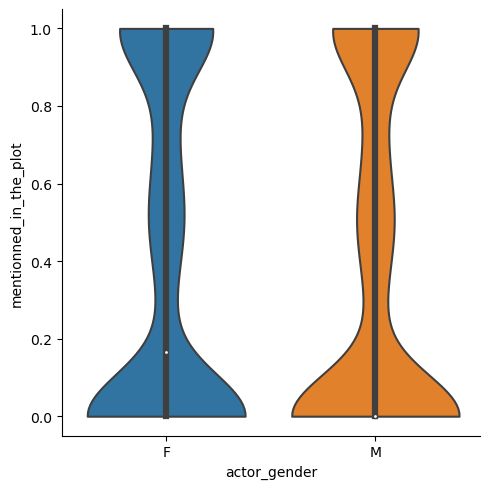

In [263]:
# Violin plot to show the distribution of the ratio of mention in plot summaries accross for both actors and actress
ax = sns.catplot(y = 'mentionned_in_the_plot', x = 'actor_gender', data = characters_grouped, kind = "violin", cut = 0, bw = .25)

### 10.3 - Importance by the popularity of the movie

- Another method to quantify the importance of a character is to compare the ratio of female between movies with different popularities. Here we will consider that a movie with a **higher number of votes on IMDB** is **more popular**. 

- We first merge movies_female with imdb to get the number of votes on IMDB for each movie. 

In [97]:
# Merge movies with female ratio and dataset with number of votes on freebase_movie_ID
popularity = movies_female.merge(imdb, left_on='freebase_movie_ID', right_on='freebase_movie_ID')
popularity.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,...,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],...,0,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55235
1,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],...,1,tt0094806,movie,Brun bitter,Brun bitter,1988,83,"Crime,Drama",5.7,40
2,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],...,2,tt0083949,movie,A Woman in Flames,Die flambierte Frau,1983,106,Drama,6.0,589
3,13696889,/m/03cfc81,The Gangsters,1913.0,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",[/m/09c7w0],...,3,tt0002894,short,The Gangsters,The Gangsters,1913,35,"Comedy,Short",6.8,16
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",[/m/09c7w0],...,4,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2159


- We now compute the percentage of female for each number of votes. 

In [98]:
# Group dataset by number of votes and compute mean female ratio 
popularity_females = popularity.groupby(popularity['numVotes'])[['female']].mean()
popularity_females.head()

,female
numVotes,
5,0.404840
6,0.349076
7,0.345191
8,0.376135
9,0.342041


- To plot this distribution, we can do a **hexplot** with the number of votes on the x-axis and the percentage of female on the y-axis. 

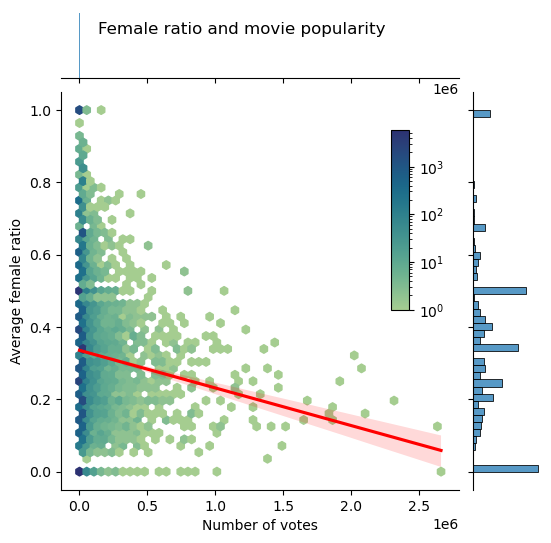

In [100]:
hexplot = sns.jointplot(x=popularity['numVotes'], y=popularity['female'], kind="hex", bins='log', cmap="crest")
sns.regplot(x=popularity['numVotes'], y=popularity['female'], ax=hexplot.ax_joint, scatter=False, color='red')
plt.ylabel('Average female ratio')
plt.xlabel('Number of votes')
plt.subplots_adjust(left=0.2, right=1, top=1, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = hexplot.fig.add_axes([.75, .5, .03, .3])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.suptitle('Female ratio and movie popularity')
plt.show()

- We can see that the percentage of female decreases when the number of votes increases, which confirms what we could have expected: the more popular a film is, the lower the percentage of female playing in this movie is. 

- We can also determine whether there is a correlation between the number of votes and the percentage of female. 

In [103]:
# Compute Pearson correlation coefficient
stats.spearmanr(popularity['numVotes'],popularity['female'])

SpearmanrResult(correlation=-0.0021529301365330765, pvalue=0.6715463946096785)

- There is a small negative, but non significant correlation. 

---

## 11 - Can women develop their carreer in cinema? 

### 11.1 - Get the data and build the dataframe

We build a dataFrame with the following information:
- Freebase_movie_ID
- nb_character
- ratio_f_character
- rating
- votes

The following dataframe are used: 
- *characters_gender*: carries the information on the characters for whom there is a gender reported
- *imdb*: the processed dataframe with imdb rating information

In [153]:
# Get all movie that appear in character_data variable
movie_list = characters_gender['freebase_movie_ID'].unique()

# Remove empty values from movie_list
movie_list = movie_list[~pd.isnull(movie_list)]

# Create a dataframe with all the movie ID
movie_character = pd.DataFrame({'freebase_movie_ID': movie_list})

# Merge the movie_character dataframe with the imdb_data dataframe and keep columns sum and rating
movie_character = pd.merge(movie_character, imdb[['freebase_movie_ID','numVotes','averageRating']], on='freebase_movie_ID', how='left')

# Drop all movies with no rating or votes
movie_character = movie_character.drop(movie_character[movie_character.numVotes.isnull()].index)
movie_character = movie_character.drop(movie_character[movie_character.averageRating.isnull()].index)

# Add column "nb_character" to movie_character with number of character per movie
character_per_movie = characters_gender.groupby('freebase_movie_ID').size().reset_index(name='nb_character')
movie_character = movie_character.merge(character_per_movie, on='freebase_movie_ID', how='left')

# Get number of character played by a female actor per movie
character_f_per_movie = characters_gender[characters_gender['actor_gender'] == 'F'].groupby('freebase_movie_ID').size().reset_index(name='f_character')

# Add column "ratio_f_character" to movie_character with ratio of female character per movie
movie_character = movie_character.merge(character_f_per_movie, on='freebase_movie_ID', how='left')

# Change Nan values to 0
movie_character = movie_character.fillna(0)

# Add ratio column
movie_character["ratio"] = movie_character["f_character"] / movie_character["nb_character"]

# Keep 2 decimals
movie_character["ratio"] = movie_character["ratio"].round(2)

movie_character.head()

,freebase_movie_ID,numVotes,averageRating,nb_character,f_character,ratio
0,/m/03vyhn,55235.0,4.9,17,6.0,0.35
1,/m/0crgdbh,40.0,5.7,4,2.0,0.50
2,/m/01mrr1,589.0,6.0,3,1.0,0.33
3,/m/06yc6v,36604.0,7.2,14,8.0,0.57
4,/m/017n1p,272.0,5.4,2,1.0,0.50


### 2 - Clean the data

In this part: 
- we remove the entries for which we do not have the movie data
- we group by actors

In [158]:
# Keep the movies in character_data that are in movie_character
character_data = characters_gender[characters_gender.freebase_movie_ID.isin(movie_character.freebase_movie_ID)]

# Merge the character_data dataframe with the movie_character dataframe
working_data = pd.merge(character_data, movie_character, on='freebase_movie_ID', how='left')

# Drop columns that are not needed
working_data = working_data.drop(['wiki_movie_ID','movie_release_date','character_name','actor_DOB', 'actor_height', 'actor_ethnicity',\
     'actor_name', 'actor_age_movie', 'freebase_char/actor_map_ID', 'freebase_char_ID'], axis=1)

working_data.head()

,freebase_movie_ID,actor_gender,freebase_actor_ID,female,numVotes,averageRating,nb_character,f_character,ratio
0,/m/03vyhn,F,/m/03wcfv7,True,55235.0,4.9,17,6.0,0.35
1,/m/03vyhn,F,/m/0346l4,True,55235.0,4.9,17,6.0,0.35
2,/m/03vyhn,M,/m/01vw26l,False,55235.0,4.9,17,6.0,0.35
3,/m/03vyhn,M,/m/034hyc,False,55235.0,4.9,17,6.0,0.35
4,/m/03vyhn,F,/m/01y9xg,True,55235.0,4.9,17,6.0,0.35


In [159]:
# Groupby freebase_actor_ID
working_data = working_data.groupby('freebase_actor_ID').agg({'freebase_movie_ID': 'count', 'numVotes': 'mean', 'averageRating': 'mean', 'nb_character': 'mean', 'f_character': 'mean', 'ratio': 'mean'}).reset_index()

# Add actor_gender column
working_data = working_data.merge(character_data[['actor_gender', "freebase_actor_ID"]], on='freebase_actor_ID', how='left')

# Remove duplocates of freebase_actor_ID
working_data = working_data.drop_duplicates(subset='freebase_actor_ID', keep="first")
working_data = working_data.rename(columns={'freebase_movie_ID': 'nb_movies'})

# Round ratio to 2 decimals
working_data["ratio"] = working_data["ratio"].round(2)
working_data["numVotes"] = working_data["numVotes"].round(0)
working_data["averageRating"] = working_data["averageRating"].round(1)
working_data["nb_character"] = working_data["nb_character"].round(0)
working_data["f_character"] = working_data["f_character"].round(0)

working_data.head()

,freebase_actor_ID,nb_movies,numVotes,averageRating,nb_character,f_character,ratio,actor_gender
0,/m/010p3,8,8144.0,5.6,12.0,3.0,0.28,M
8,/m/010q36,1,135711.0,6.1,16.0,3.0,0.19,M
9,/m/010wx,1,429.0,5.9,4.0,2.0,0.50,F
10,/m/010xjr,36,83190.0,6.6,11.0,3.0,0.24,M
46,/m/0112yl,34,29938.0,7.3,9.0,2.0,0.22,M


In [161]:
# Divide the working_data dataframe into 2 dataframe based on the actor_gender
working_data_f = working_data[working_data.actor_gender == 'F']
working_data_m = working_data[working_data.actor_gender == 'M']

working_data_f.head()

,freebase_actor_ID,nb_movies,numVotes,averageRating,nb_character,f_character,ratio,actor_gender
9,/m/010wx,1,429.0,5.9,4.0,2.0,0.50,F
82,/m/011_2h,1,866.0,6.0,14.0,6.0,0.43,F
83,/m/011_3s,28,19861.0,6.4,13.0,6.0,0.48,F
114,/m/011_c4,4,16631.0,7.0,10.0,4.0,0.44,F
224,/m/011k9b,1,44.0,7.6,4.0,4.0,1.00,F


### 3 - Do women feature in more movies than men? 

- To assess the development of career of an actor or actress, we will look at the number of movies in which he or she played.

- We can plot the histogram to visualize this distribution using **log axes**. 

Text(0.5, 1.0, 'Distribution of the number of movies played by actors and actresses in the dataset')

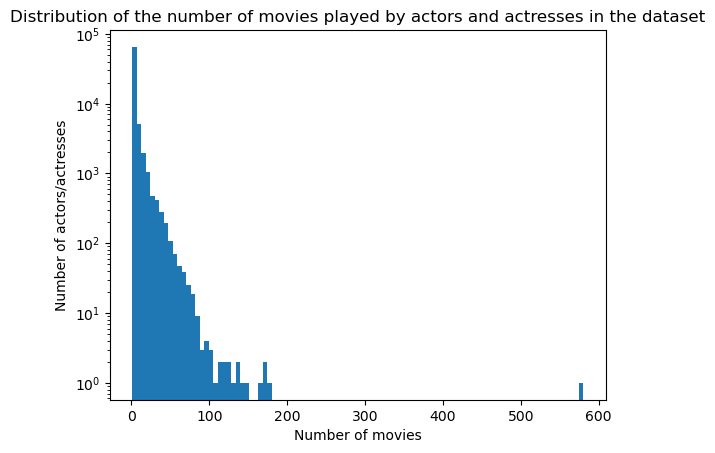

In [168]:
histogram_num_movies = plt.hist(working_data['nb_movies'], bins = 100, log=True)
plt.xlabel('Number of movies')
plt.ylabel('Number of actors/actresses')
plt.title('Distribution of the number of movies played by actors and actresses in the dataset')

- We can see that the distribution is **skewed**. Most of the actors or actresses have played less than 100 movies, and few actors or actresses have played in up to 800 movies. 

- We now want to determine whether there is a difference in the number of movies played by actors and actresses. 

In [172]:
# we will count the total number of females and males to normalize our results
number_female_male = working_data.groupby(working_data['actor_gender']).size()
print("There are {} actresses and {} actors in the dataset.".format(number_female_male.loc[number_female_male.index=='F'].values[0], \
     number_female_male.loc[number_female_male.index=='M'].values[0]))

There are 27664 actresses and 47102 actors in the dataset.


In [174]:
# We group by the number of movies and we count the ratio of actresse and actors  
ratio_f_m_per_number_of_movies = working_data.groupby(['nb_movies','actor_gender'])[['freebase_actor_ID']].count()

# We normalize by the total number of females/males
ratio_f_m_per_number_of_movies.loc[(slice(None),'F'),:] = ratio_f_m_per_number_of_movies.loc[(slice(None),'F'),:]/number_female_male.loc[number_female_male.index=='F'].values[0]
ratio_f_m_per_number_of_movies.loc[(slice(None),'M'),:] = ratio_f_m_per_number_of_movies.loc[(slice(None),'M'),:]/number_female_male.loc[number_female_male.index=='M'].values[0]
ratio_f_m_per_number_of_movies.head()

freebase_actor_ID
nb_movies actor_gender                   
1         F                      0.555451
          M                      0.546537
2         F                      0.152256
          M                      0.142053
3         F                      0.073670

In [175]:
# We extract only the data on female 
career_fem = ratio_f_m_per_number_of_movies.loc[(slice(None),'F'),:]
career_fem.head()

,,freebase_actor_ID
nb_movies,actor_gender,
1,F,0.555451
2,F,0.152256
3,F,0.073670
4,F,0.046920
5,F,0.029786


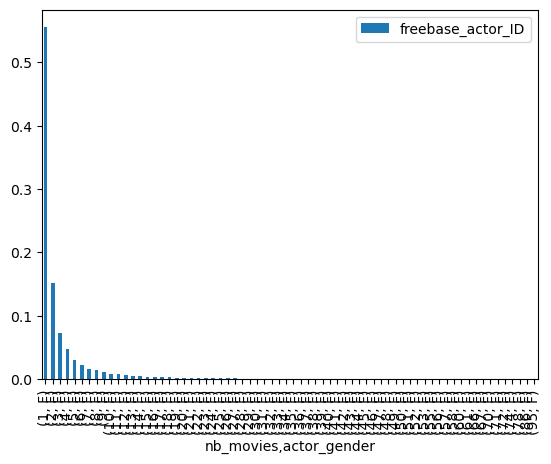

In [179]:
# We plot the distribution 
ax= career_fem.plot.bar()

In [176]:
# We extract only the data on male
career_male = ratio_f_m_per_number_of_movies.loc[(slice(None),'M'),:]
career_male.head()

,,freebase_actor_ID
nb_movies,actor_gender,
1,M,0.546537
2,M,0.142053
3,M,0.072354
4,M,0.044711
5,M,0.031464


<AxesSubplot:xlabel='nb_movies,actor_gender'>

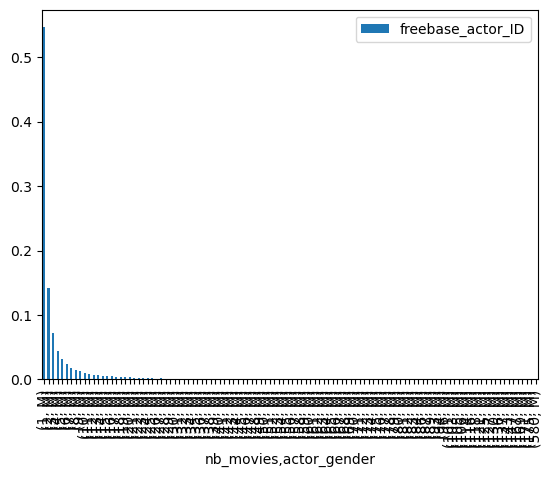

In [180]:
# We plot the distribution
career_male.plot.bar()

[Text(0.5, 1.0, 'Number of movies by genre')]

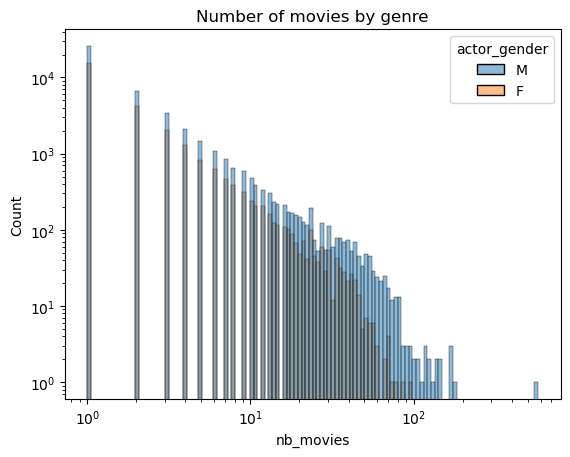

In [181]:
# We can plot the distribution
sns.histplot(data=working_data, x="nb_movies", hue="actor_gender", log_scale=(True, True)).set(title='Number of movies by genre')

- We can see that over the distribution, **actors individually played in more movies than actresses**, and this tendency increases with the number of movies, as the difference between male and female is more important for a high number of movies by actor/actress. 

- To visualize this information differently, we plot the CCDF of the number of actors in function of the number of movies for male and female characters. 

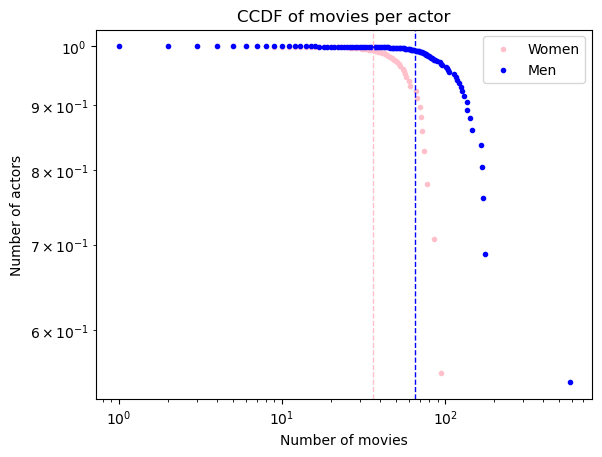

['Bette Davis']
24


In [162]:
working_data_f_movies = working_data_f.groupby('nb_movies').size()
working_data_m_movies = working_data_m.groupby('nb_movies').size()

working_data_f_movies = working_data_f_movies / working_data_f_movies.sum()
working_data_m_movies = working_data_m_movies / working_data_m_movies.sum()

# Plot number of movies distribution per gender
plt.scatter(working_data_f_movies.index, working_data_f_movies.cumsum()[::-1], label="Women", color='pink', marker = '.')
plt.scatter(working_data_m_movies.index, working_data_m_movies.cumsum()[::-1], label="Men", color='blue', marker = '.')

# Add vertical line at the mean
plt.axvline(working_data_m_movies.index.values.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(working_data_f_movies.index.values.mean(), color='pink', linestyle='dashed', linewidth=1)
plt.title('CCDF of movies per actor')
plt.xlabel('Number of movies')
plt.ylabel('Number of actors')
plt.legend()
plt.loglog()
plt.show()

# Get actor name based on freebase_actor_ID
print(character_data[character_data.freebase_actor_ID ==\
     working_data_f[working_data_f.nb_movies > 90].freebase_actor_ID.values[0]].actor_name.unique())

# Number of actors who featured in more than 90 movies
print(working_data_m[working_data_m.nb_movies > 90].freebase_actor_ID.count())

- Eventhough the repartition of number of movies featured in is very similar between men and women for <40~50 movies, there is only one women who featured in more than 90 movies (Bette Davis), compared to 24 men. Therefore we can say than men feature in more movies than women. 

- We now convert the plot to Plotly and export it for the datastory

In [163]:
# Convert the data into a Plotly-compatible format
data = {'Number of movies': working_data_f_movies.index, 
        'Number of actors': working_data_f_movies.cumsum()[::-1],
        'Gender': ['Women']*len(working_data_f_movies)}
data = pd.DataFrame(data)

# Add the data for men to the dataframe
data_m = {'Number of movies': working_data_m_movies.index, 
          'Number of actors': working_data_m_movies.cumsum()[::-1],
          'Gender': ['Men']*len(working_data_m_movies)}
data_m = pd.DataFrame(data_m)
data = pd.concat([data, data_m])

# Create the plot
fig = px.scatter(data, x='Number of movies', y='Number of actors', color='Gender', log_x=True, log_y=True)

# Add vertical lines at the mean for each gender
fig.add_shape(type='line', x0=working_data_m_movies.index.values.mean(), y0=0, x1=working_data_m_movies.index.values.mean(), y1=1, yref='paper', xref='x', line=dict(color='blue', dash='dash'))
fig.add_shape(type='line', x0=working_data_f_movies.index.values.mean(), y0=0, x1=working_data_f_movies.index.values.mean(), y1=1, yref='paper', xref='x', line=dict(color='pink', dash='dash'))

# Update the layout
fig.update_layout(title='CCDF of movies per actor', xaxis_title='Number of movies', yaxis_title='Number of actors', showlegend=True)

# Export the plot as an HTML file
fig.write_html('plot.html')

### 4 - Is the average rating of  movies different depending on the percentage of male and female characters? 

- In this part, we want to examine whether the average rating of movies in which women played is different from the one in which men played. 

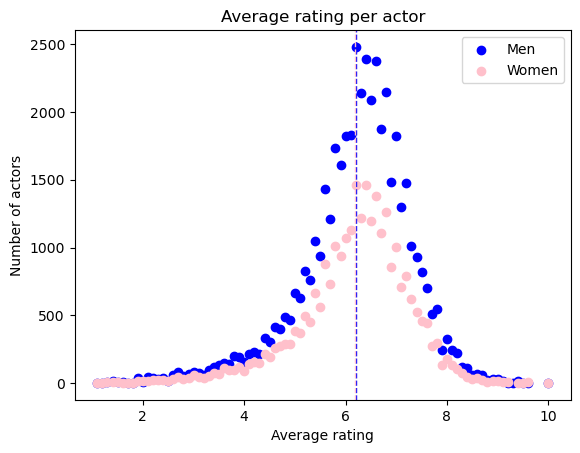

In [164]:
working_data_f_rating = working_data_f.groupby('averageRating').size()
working_data_m_rating = working_data_m.groupby('averageRating').size()

# Compute weighted average
m_avg = np.average(working_data_m_rating.index, weights=working_data_m_rating)
f_avg = np.average(working_data_f_rating.index, weights=working_data_f_rating)

to_plotly = plt.figure()

plt.scatter(working_data_m_rating.index, working_data_m_rating, color='blue', label = 'Men')
plt.scatter(working_data_f_rating.index, working_data_f_rating, color='pink', label = 'Women' )

# Add vertical line at the mean
plt.axvline(m_avg, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(f_avg, color='pink', linestyle='dashed', linewidth=1)
plt.title('Average rating per actor')
plt.xlabel('Average rating')
plt.ylabel('Number of actors')
plt.legend()
plt.show()

- Both distribution are bell curves with a mean of 6.1 and a std of 1.05. There is no difference between men and women except that the total number of actors is higher for men than women. However, the average rating is the same and this parameter does not seem to be a differentiating factor between men and women. 

- We also convert the plot to plotly and export it for the datastory. 

In [165]:
# Convert the data into a Plotly-compatible format
data = {'average rating': working_data_f_rating.index, 
        'Number of actors': working_data_f_rating,
        'Gender': ['Women']*len(working_data_f_rating)}
data = pd.DataFrame(data)

# Add the data for men to the dataframe
data_m = {'average rating': working_data_m_rating.index, 
          'Number of actors': working_data_m_rating,
          'Gender': ['Men']*len(working_data_m_rating)}
data_m = pd.DataFrame(data_m)
data = pd.concat([data, data_m])

# Create the plot
fig = px.scatter(data, x='average rating', y='Number of actors', color='Gender', log_x=False, log_y=False)

# Add vertical lines at the mean for each gender
fig.add_shape(type='line', x0=m_avg, y0=0, x1=m_avg, y1=1, yref='paper', xref='x', line=dict(color='blue', dash='dash'))
fig.add_shape(type='line', x0=f_avg, y0=0, x1=f_avg, y1=1, yref='paper', xref='x', line=dict(color='pink', dash='dash'))

# Update the layout
fig.update_layout(title='Average rating per actor', xaxis_title='Average rating', yaxis_title='Number of actors', showlegend=True)

# Export the plot as an HTML file
fig.write_html('plotRating.html')